<a href="https://colab.research.google.com/github/SasithWickrama/Enterprise_Mobility/blob/main/fccImageCaptue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [ ]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 7s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
import os
from google.colab import drive
from tqdm import tqdm
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.models import Model

# Mount Google Drive
drive.mount('/content/drive')

# Set base directory
BASE_DIR = '/content/drive/MyDrive/kaggle/input/flickr8k/'
WORKING_DIR = '/kaggle/working'

# Load the pre-trained VGG16 model
model = VGG16()
# Remove the last layer (output layer) from the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Extract features from images
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to numpy array
    image = img_to_array(image)
    # Reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess image for VGG
    image = preprocess_input(image)
    # Extract features
    feature = model.predict(image, verbose=0)
    # Get image ID
    image_id = img_name.split('.')[0]
    # Store feature
    features[image_id] = feature
# store features in pickle

pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  7%|▋         | 597/8102 [08:44<1:10:42,  1.77it/s]

In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set base directory
BASE_DIR = '/content/drive/MyDrive/kaggle/input/flickr8k/'

# Read captions from file
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)  # Skip the first line if needed
    captions_doc = f.read()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os
from google.colab import drive
from tqdm import tqdm  # Import tqdm for creating progress bars

# Mount Google Drive
drive.mount('/content/drive')

# Set base directory
BASE_DIR = '/content/drive/MyDrive/kaggle/input/flickr8k/'

# Read captions from file
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)  # Skip the first line if needed
    captions_doc = f.read()

# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)


Mounted at /content/drive


100%|██████████| 40456/40456 [00:00<00:00, 385149.99it/s]


In [7]:
len(mapping)

8091

In [8]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Delete digits, special characters, etc.
            caption = caption.replace('[^A-Za-z]', '')
            # Delete additional spaces
            caption = caption.replace('\s+', ' ')
            # Add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption


In [9]:
# before preprocess of text
mapping['3767841911_6678052eb6']

['A baby girl in an orange dress gets wet as she stands next to a water sprinkler .',
 'A blonde toddler wearing an orange dress is wet and standing beside a sprinkler in a yard .',
 'A child in a dress is looking at a sprinkler',
 'A little girl in an orange dress is running through the sprinkler in the yard .',
 '"On wet grass   little blond girl in orange dress plays in sprinkler ."']

In [10]:
# preprocess the text
clean(mapping)

In [11]:
# after preprocess of text
mapping['3767841911_6678052eb6']

['startseq baby girl in an orange dress gets wet as she stands next to water sprinkler endseq',
 'startseq blonde toddler wearing an orange dress is wet and standing beside sprinkler in yard endseq',
 'startseq child in dress is looking at sprinkler endseq',
 'startseq little girl in an orange dress is running through the sprinkler in the yard endseq',
 'startseq "on wet grass little blond girl in orange dress plays in sprinkler ." endseq']

In [12]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [13]:
len(all_captions)

40455

In [14]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [15]:
from keras.preprocessing.text import Tokenizer

all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Now you can use the tokenizer object to tokenize your text


In [ ]:
vocab_size

8485

In [ ]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [16]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

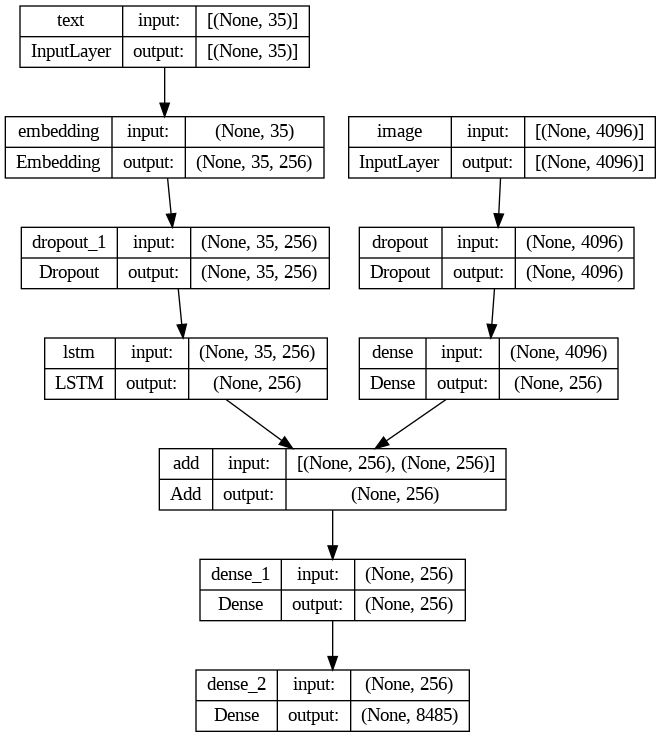

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# Assuming 'mapping' contains image captions
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

max_length = max(len(caption.split()) for caption in all_captions)
captions_padded = {}

for img_id, img_captions in mapping.items():
    sequences = tokenizer.texts_to_sequences(img_captions)
    padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
    captions_padded[img_id] = padded_sequences

# Define encoder model
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Define decoder model
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Merge models
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Define the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model architecture
plot_model(model, to_file='/content/drive/MyDrive/kaggle/working/model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
# Define the data generator function
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = [], [], []
    n = 0
    while True:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                if n == batch_size:
                    X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                    yield {"image": X1, "text": X2}, y
                    X1, X2, y = [], [], []
                    n = 0

# Train the model using the data generator
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
---------------------Actual---------------------
A baby girl in an orange dress gets wet as she stands next to a water sprinkler
A blonde toddler wearing an orange dress is wet and standing beside a sprinkler in a yard
A child in a dress is looking at a sprinkler
A little girl in an orange dress is running through the sprinkler in the yard
On wet grass , little blond girl in orange dress plays in sprinkler
--------------------Predicted--------------------
startseq


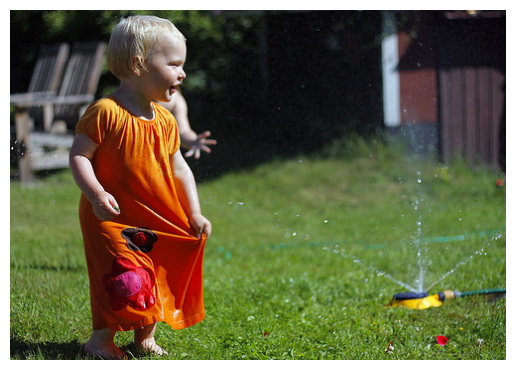

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
import os
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.models import Model
from tensorflow.keras.utils import plot_model

# Mount Google Drive
drive.mount('/content/drive')

# Define base directory for images in Google Drive
BASE_DIR = '/content/drive/My Drive/kaggle/input/flickr8k/Images'

# Define the function to generate and display captions for an image
def generate_caption(image_name, mapping, model, features, tokenizer, max_length):
    # Extract image ID
    image_id = image_name.split('.')[0]

    # Construct image path
    img_path = os.path.join(BASE_DIR, image_name)

    # Check if the image file exists
    if os.path.exists(img_path):
        # Load the image
        image = Image.open(img_path)

        # Retrieve captions for the image from mapping
        captions = mapping.get(image_id, [])

        # Display actual captions
        print('---------------------Actual---------------------')
        for caption in captions:
            print(caption)

        # Predict and display the caption
        y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
        print('--------------------Predicted--------------------')
        print(y_pred)

        # Display the image
        plt.imshow(image)
        plt.axis('off')  # Hide axis
        plt.show()
    else:
        print(f"Image file {image_name} not found.")


def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)

        # Predict next word
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)

        if word is None:
            break

        in_text += " " + word
        if word == 'endseq':
            break

    return in_text

# Define the model for caption generation
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

# Sample model, features, tokenizer, and max_length
vocab_size = 10000
max_length = 100
model = define_model(vocab_size, max_length)
features = {"3767841911_6678052eb6": np.random.randn(1, 4096)}  # Example features
tokenizer = Tokenizer()

# Call the function with the image name and the mapping variable
generate_caption("3767841911_6678052eb6.jpg", mapping, model, features, tokenizer, max_length)
